## Airline Data Modeling

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from scipy.spatial.distance import euclidean as euc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [35]:
df_model = pd.read_csv("/Users/Tara8082/GIT/ProjectGIT/Project_3/df_clean.csv", index_col = 0)

In [36]:
# Designating 'neutral or dissatisfied' as 1

df_model['Satisfaction'] = df_model['Satisfaction'].apply(lambda x: 1 if x == 'neutral or dissatisfied' else 0)

In [72]:
features = ['Gender', 'Customer Type', 'Age', 'Type Of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Dep Arr Time Convenience',
       'Ease Of Online Booking', 'Gate Location', 'Food And Drink',
       'Online Boarding', 'Seat Comfort', 'Inflight Entertainment',
       'Onboard Service', 'Leg Room Service', 'Baggage Handling',
       'Checkin Service', 'Inflight Service', 'Cleanliness',
       'Departure Delay In Minutes']

X = df_model[features]
y = df_model['Satisfaction']


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=6)

In [74]:
# Specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type Of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight Wifi Service',
       'Dep Arr Time Convenience', 'Ease Of Online Booking',
       'Gate Location', 'Food And Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'Onboard Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay In Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_train.index)

# Combine continuous and categorical train data
X_train_preprocessed = pd.concat([X_train[non_cat], X_train_ohe], axis=1)

# Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)

In [75]:
# Create validation set with X_train_preprocessed data

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_preprocessed, y_train, test_size=.3, random_state=2)

In [76]:
# Transform and scale testing set --- DON'T TOUCH TEST UNTIL END.

cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=X_test.index)

# Combine continuous and categorical test data
X_test_preprocessed = pd.concat([X_test[non_cat], X_test_ohe], axis=1)

# Scale test data
X_test_preprocessed = ss.transform(X_test_preprocessed)

### Logistic Regression Model on Train/Val data


In [42]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

log_y_val_preds = lr.predict(X_val_scaled)

#test_log_preds = lr.predict(X_test_preprocessed) #DON'T RUN

print(classification_report(y_val, log_y_val_preds))

# positive outcome is dissatisfaction (identify  more dissastisfied possible with lower degree of accuracy)
# cost of being wrong? 1% decrease in recall?

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11782
           1       0.88      0.90      0.89     15410

    accuracy                           0.88     27192
   macro avg       0.88      0.87      0.87     27192
weighted avg       0.88      0.88      0.88     27192



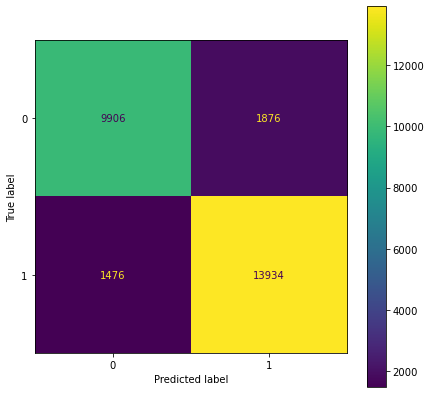

In [43]:
# Confusion Matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax); ## IS THIS RIGHT???

## K Nearest Neighbors on Train/Val Data

In [65]:
# Testing for optimal k

ks = range(1, 15)
test_errors = np.zeros(len(list(ks)))

for i,k in enumerate(ks):
    
    # Using nn for testing k
    nn = KNeighborsClassifier(n_neighbors = k)

    nn.fit(X_train_scaled, y_train)
    test_k_preds = nn.predict(X_val_scaled)
    
    test_errors[i] = np.sqrt(mean_squared_error(y_val, test_k_preds))
    print(k, test_errors[i])

1 0.2945393978724883
2 0.3018161170649324
3 0.2728927123983732
4 0.2723531316185696
5 0.2712029579942498
6 0.26593106101859343
7 0.26950260920725877
8 0.26627656078884776
9 0.26984353611043294
10 0.2684772309458182
11 0.2715417500788652
12 0.2690929267674012
13 0.27336397190490946
14 0.27072793680989765


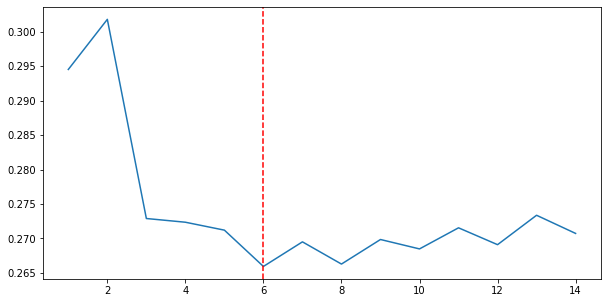

In [69]:
# graph K test_error scores
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), test_errors)
ax.axvline(list(ks)[np.argmin(test_errors)], linestyle='--', color='red');

In [70]:
optimal_k = list(ks)[np.argmin(test_errors)]

optimal_error = np.min(test_errors)

print(f'Optimal number of Neighbors: {optimal_k}\nRoot Mean Squared Error: {optimal_error:.3f}')

Optimal number of Neighbors: 6
Root Mean Squared Error: 0.266


## KNN with Optimal k

In [77]:
knn = KNeighborsClassifier(n_neighbors = optimal_k)

knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_val_scaled)

In [78]:
knn_cm = confusion_matrix(y_val, knn_preds)
knn_cm

array([[10585,  1197],
       [  726, 14684]])

In [79]:
print("Training score: ", knn.score(X_train_scaled, y_train))
print("Validation score: ", knn.score(X_val_scaled, y_val))

Training score:  0.9463970495523893
Validation score:  0.9292806707855251


In [80]:
print(classification_report(y_val, knn_preds))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     11782
           1       0.92      0.95      0.94     15410

    accuracy                           0.93     27192
   macro avg       0.93      0.93      0.93     27192
weighted avg       0.93      0.93      0.93     27192



In [ ]:
model = 'KNN (k={})'.format(optimal_k)
plot_cm(knn_cm, normalize=False, target_names=['satisfied', 'neutral/dissatisfied'], title='Confusion Matrix: {}'.format(model))

### KNN Cross Validating

In [82]:
df2 = df_model.copy()
features = ['Gender', 'Customer Type', 'Age', 'Type Of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Dep Arr Time Convenience',
       'Ease Of Online Booking', 'Gate Location', 'Food And Drink',
       'Online Boarding', 'Seat Comfort', 'Inflight Entertainment',
       'Onboard Service', 'Leg Room Service', 'Baggage Handling',
       'Checkin Service', 'Inflight Service', 'Cleanliness',
       'Departure Delay In Minutes']

X = df2[features]
y = df2['Satisfaction']

In [83]:
X, x_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=6)

In [84]:
# Specify categorical features

categoricals = ['Gender', 'Customer Type', 'Type Of Travel', 'Class']
non_cat = ['Flight Distance', 'Inflight Wifi Service',
       'Dep Arr Time Convenience', 'Ease Of Online Booking',
       'Gate Location', 'Food And Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'Onboard Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay In Minutes']

ohe = OneHotEncoder(sparse=False)

cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals),
                           index=X.index)

# Combine continuous and categorical train data
X_cval = pd.concat([X[non_cat], X_train_ohe], axis=1)

# Scale data
ss = StandardScaler()
X_cval = ss.fit_transform(X_cval)

In [85]:
knn = KNeighborsClassifier(n_neighbors = 6)
cross_val_score(knn, X_cval, y, cv=5)

array([0.92883936, 0.9250331 , 0.93110106, 0.92889453, 0.92409532])

In [86]:
ks = range(1, 30)

cv_scores = np.zeros(len(list(ks)))

for i, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_score_mean = cross_val_score(knn, X_cval, y, cv=3).mean()
    cv_scores[i] = cv_score_mean

In [87]:
best_k = list(ks)[np.argmax(cv_scores)]

best_score = np.max(cv_scores)

print(f'Optimal number of Neighbors: {best_k}\nBest CV Score Mean: {best_score:.5f}')

Optimal number of Neighbors: 6
Best CV Score Mean: 0.92739


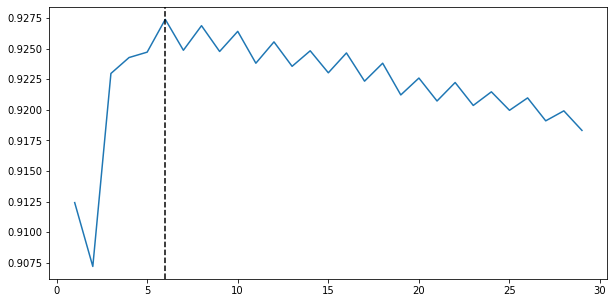

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(list(ks), cv_scores)
ax.axvline(list(ks)[np.argmax(cv_scores)], linestyle='--', color='black');